In [1]:
import numpy
import pandas
import morphio
import conntility
import os

from scipy.spatial import distance

root_morph = "/gpfs/bbp.cscs.ch/project/proj3/projects-data/2023.12.18-microns-skeletonization"
conn_fn = "/gpfs/bbp.cscs.ch/home/reimann/data/mm3/microns_mm3_connectome.h5"

root_morph_out = "./translated"
root_sonata_out = "./sonata"
sonata_edges = "edges.h5"
sonata_nodes = "nodes.h5"
node_population = "default"
edge_population = "default"

M = conntility.ConnectivityMatrix.from_h5(conn_fn, "full")

# Read contents of root_morph.
Finds all swc files in Marwan's morphology release and creates a Series where the index is the "pt_root_id" and the value is the path to the morphology file

In [2]:
subdirs = [_x for _x in os.listdir(root_morph) if _x.startswith("2023")]

def dir_to_series(root):
    fns = [_x for _x in os.listdir(root) if 
           os.path.isfile(os.path.join(root, _x)) and 
           os.path.splitext(_x)[1] == ".swc"]
    return pandas.Series([
        os.path.join(root, _x) for _x in fns
    ], index=[
        int(os.path.splitext(_x)[0]) for _x in fns
    ])

morph_series = dir_to_series(os.path.join(root_morph, subdirs[0]))

# Generate subnetwork
Create the subgraph of M that contains all nodes that are contained in the release, plus the edges between them

In [3]:
lookup = M._vertex_properties["pt_root_id"].reset_index().set_index("pt_root_id")["index"]
S = M.subpopulation(lookup[morph_series.index].values)

# Translate morphologies
This is not strictly necessary, but we prefer morphologies that are centered with their soma at the origin.
The location of the neuron is then given as a node property.

Here, we create copies of all morphologies that are translated by the corresponding node location in M.

In [4]:
def translate_morphology(m, offset, out_fn):
    mm = m.as_mutable()
    offset = offset.reshape((1, -1))
    mm.soma.points = mm.soma.points - offset
    for sec in mm.iter():
        sec.points = sec.points - offset

    m2 = mm.as_immutable()
    mm.write(out_fn)
    return m2

morph_series_tl = {} # As morph_series, but for the translated morphology files

for i, nrn in S.vertices.iterrows():
    offset = (nrn[["x_nm", "y_nm", "z_nm"]] / 1000).values.reshape((1, -1))
    m = morphio.Morphology(morph_series[nrn["pt_root_id"]])
    _, fn_base = os.path.split(morph_series[nrn["pt_root_id"]])
    fn_out = os.path.join(root_morph_out, fn_base)
    m2 = translate_morphology(m, offset, fn_out)
    morph_series_tl[nrn["pt_root_id"]] = fn_out

morph_series_tl = pandas.DataFrame(morph_series_tl, index=["path"]).transpose()["path"]

# Create Sonata-compatible synapse DataFrame
This is the only really complex step.
While M.edges is already a DataFrame of synapse properties, we will have to make it Sonata compatible.

That comprises renaming some columns, moving from nm to um. But also looking up the section and segment ids where all synapses are placed. So, we do a bit of 3d geometry here.

In [71]:
m.section(4).diameters

array([0.88081 , 0.88081 , 0.88081 , 0.88081 , 0.88081 , 0.88081 ,
       0.88086 , 0.88081 , 0.88081 , 0.88081 , 0.2     , 0.2     ,
       0.88081 , 0.88081 , 0.88081 , 0.88081 , 0.88081 , 0.88081 ,
       0.88081 , 0.88081 , 1.245758, 0.88081 , 0.88081 , 0.88081 ,
       0.88081 , 0.88081 , 0.88081 , 0.88081 , 0.88081 , 0.88081 ,
       0.88081 , 0.88081 , 0.88081 , 0.88081 , 0.88081 , 0.88081 ,
       0.88081 , 0.88081 , 0.2     , 0.88081 , 0.88081 , 1.245758,
       0.88081 , 0.88081 , 0.88081 , 0.88081 , 0.88081 , 0.88081 ,
       0.653874], dtype=float32)

In [86]:
def morphology(nrn):
    m = morphio.Morphology(morph_series[nrn["pt_root_id"]])
    return m

def point_segment_distances(sec_pts, sec_radii, syn_locs, from_surface=True):
    if len(syn_locs) == 0:
        return numpy.empty((0, len(sec_pts) - 1)), numpy.empty((0, len(sec_pts) - 1)), \
          numpy.empty((0, len(sec_pts) - 1, 3))
    # Distances from the start and end points of segments
    dist_start = distance.cdist(syn_locs, sec_pts[:-1])
    dist_end = distance.cdist(syn_locs, sec_pts[1:])

    d_sec = numpy.diff(sec_pts, axis=0) # segs x 3
    # lengths of all segments
    seg_len = numpy.linalg.norm(d_sec, axis=1, keepdims=True) # segs x 1
    # Normalized vectors indicating the direction of each segment
    d_sec = d_sec / seg_len # segs x 3
    # Vectors indicating offsets from the start points of each segment to each synapse
    d_syn = syn_locs.reshape((-1, 1, 3)) - sec_pts[:-1].reshape((1, -1, 3)) # syns x segs x 3
    # Lengths of these vectors
    dist_syn = numpy.linalg.norm(d_syn, axis=-1, keepdims=True) # syns x segs x 1
    # Normalized vectors indicating the directions from segment start points to synapses
    d_syn_norm = d_syn / dist_syn # syns x segs x 3

    # Cosine of angle between the direction of the segment and the direction to a synapse
    cos_angle = (d_syn_norm * d_sec).sum(axis=-1) # syns x segs
    # Distances between synapses and the lines defined by each segment
    pw_dist = numpy.sin(numpy.arccos(cos_angle)) * dist_syn[:, :, 0] # syns x segs

    # Distances between segment start points and the locations of synapses projected onto the line
    proj_dist = cos_angle * dist_syn[:, : , 0] # syns x segs
    # That distance < 0 indicates a location before the start point. Use distance from start point instead
    pw_dist[proj_dist < 0] = dist_start[proj_dist < 0]
    # That distance > segment length indicates location after the end point. Use distance from end point instead.
    pw_dist[proj_dist > seg_len.transpose()] = dist_end[proj_dist > seg_len.transpose()]
    
    # Consequently, segment offset values are between 0 (start point) and length (end point)
    seg_offsets = numpy.maximum(numpy.minimum(proj_dist, seg_len.transpose()), 0) # syns x segs
    
    if from_surface:
        # Calculate radii at projected locations and subtract them to yield distance from surface
        nrml_offsets = seg_offsets / seg_len.transpose()
        pw_dist = pw_dist - ((1 - nrml_offsets) * sec_radii[:-1] + nrml_offsets * sec_radii[1:])
        pw_dist = numpy.maximum(pw_dist, 0)
    
    # locations in 3d of synapse locations projected onto the segments
    pts3d = sec_pts[:-1].reshape((1, -1, 3)) +\
       seg_offsets.reshape(seg_offsets.shape + (1,)) *\
       numpy.repeat(d_sec.reshape((1, -1, 3)), seg_offsets.shape[0], axis=0)
    
    return pw_dist, seg_offsets, pts3d

def point_sections_distances(m2, syn_locs, from_surface=True):
    all_pw_dist, all_offsets, all_3d = zip(*[
        point_segment_distances(_sec.points, _sec.diameters / 2, syn_locs, from_surface=from_surface)
        for _sec in m2.sections
    ])
    return numpy.hstack(all_pw_dist),\
           numpy.hstack(all_offsets),\
           numpy.hstack(all_3d)

def find_synapse_location_on_morphology(m2, syn_locs, soma_epsilon=1.0, from_surface=True):
    # Assumes morphology is centered on soma!
    dist_from_soma = numpy.linalg.norm(syn_locs, axis=1)
    is_on_soma = dist_from_soma < (soma_epsilon + m2.soma.diameters / 2)
    
    n_per_sec = numpy.diff(m2.section_offsets) - 1
    
    sec_lo = numpy.hstack([i * numpy.ones(n, dtype=int)
                           for i, n in enumerate(n_per_sec)])
    
    all_pw_dist, all_offsets, all_3d = point_sections_distances(m2, syn_locs, from_surface=from_surface)
    D = numpy.min(all_pw_dist, axis=1)
    idxx = numpy.argmin(all_pw_dist, axis=1)
    
    pts3d = all_3d[numpy.arange(all_3d.shape[0]), idxx, :] # syns x 3
    res_sec = sec_lo[idxx]
    res_seg = idxx - numpy.cumsum(numpy.hstack([0, n_per_sec]))[res_sec]
    res_off = all_offsets[numpy.arange(all_offsets.shape[0]), idxx]
    
    res_sec[is_on_soma] = -1
    res_seg[is_on_soma] = 0
    res_off[is_on_soma] = 0
    pts3d[is_on_soma, :] = [0, 0, 0]
    D[is_on_soma] = numpy.maximum(dist_from_soma[is_on_soma] - m2.soma.diameters / 2, 0)
    
    return res_sec, res_seg, res_off, D, pts3d

def location_from_morphology(m, props): # Inverse. For validation.
    for _, row in props.iterrows():
        sec_id = int(row["afferent_section_id"])
        if sec_id == -1:
            locs.append(m.soma.center)
            continue
        seg_id = int(row["afferent_segment_id"])
        sec = m.section(sec_id)
        pts = sec.points[seg_id:(seg_id + 2)]
        l = numpy.sum((pts[0] - pts[1]) ** 2)
        loc = pts[0] + (row["afferent_segment_offset"] / l) * (pts[1] - pts[0])

        locs.append(loc)

    locs = numpy.vstack(locs)
    return locs

def base_synapse_properties_df(m2, syn_locs, prefix="afferent", soma_epsilon=1.0, from_surface=True):
    res_sec, res_seg, res_off, D, pts3d = find_synapse_location_on_morphology(m2, syn_locs, soma_epsilon,
                                                                              from_surface=from_surface)
    sec_types = m2.section_types[res_sec]
    sec_types[res_sec == -1] = 1 # SOMA
    return pandas.DataFrame({
            prefix + "_section_id": res_sec,
            prefix + "_segment_id": res_seg,
            prefix + "_segment_offset": res_off,
            prefix + "_section_type": sec_types,
            prefix + "_spine_length": D, # TODO: Subtract local segment radius
            prefix + "_center_x": pts3d[:, 0],
            prefix + "_center_y": pts3d[:, 1],
            prefix + "_center_z": pts3d[:, 2]
        })
    
def synapse_properties_df(S, nrn, lst_additional_props, side="col", from_surface=True):
    prefix = "afferent"
    if side == "row": prefix = "efferent"
    m = morphology(nrn)
    Ssub = S.filter("pt_root_id", side=side).eq(nrn["pt_root_id"])
    syn_locs = Ssub.edges[["x_nm", "y_nm", "z_nm"]] / 1000
    props = base_synapse_properties_df(m, syn_locs.values, prefix=prefix, from_surface=from_surface)
    
    #xyz = Ssub.edges[["x_nm", "y_nm", "z_nm"]].reset_index(drop=True) / 1000
    xyz = syn_locs.reset_index(drop=True).rename(columns={"x_nm": prefix + "_surface_x",
                                                          "y_nm": prefix + "_surface_y",
                                                          "z_nm": prefix + "_surface_z"})
    props = pandas.concat([
        xyz,
        props,
        Ssub.edges[lst_additional_props].reset_index(drop=True)
    ], axis=1)
    
    
    idxx = pandas.DataFrame({
        "source_node_id": Ssub._edge_indices.values[:, 0],
        "target_node_id": Ssub._edge_indices.values[:, 1]
    })
    return props, idxx

### Quick validation that the results are consistent

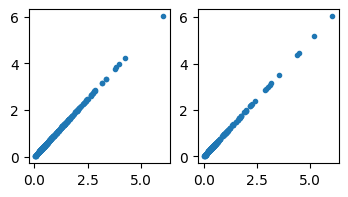

In [81]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(4, 2))
ax = fig.add_subplot(1, 2, 1)
A, B = synapse_properties_df(M, nrn, ["size"], side="col", from_surface=False)
a = ["afferent_surface_x", "afferent_surface_y", "afferent_surface_z"]
b = ["afferent_center_x", "afferent_center_y", "afferent_center_z"]
o = numpy.sqrt(numpy.sum((A[a].values - A[b].values) ** 2, axis=1)) 
ax.plot(o, A["afferent_spine_length"], '.')

ax = fig.add_subplot(1, 2, 2)
A, B = synapse_properties_df(M, nrn, ["size"], side="row", from_surface=False)
a = ["efferent_surface_x", "efferent_surface_y", "efferent_surface_z"]
b = ["efferent_center_x", "efferent_center_y", "efferent_center_z"]
o = numpy.sqrt(numpy.sum((A[a].values - A[b].values) ** 2, axis=1)) 

ax.plot(o, A["efferent_spine_length"], '.')

### Run for afferent end efferent sides. 

In [87]:
props_aff, idxx_aff = zip(*[synapse_properties_df(S, nrn, ["size", "id"], side="col") for _, nrn in S.vertices.iterrows()])
props_aff = pandas.concat(props_aff, axis=0).reset_index(drop=True)
idxx_aff = pandas.concat(idxx_aff, axis=0).reset_index(drop=True)

props_eff, idxx_eff = zip(*[synapse_properties_df(S, nrn, ["size", "id"], side="row") for _, nrn in S.vertices.iterrows()])
props_eff = pandas.concat(props_eff, axis=0).reset_index(drop=True)
idxx_eff = pandas.concat(idxx_eff, axis=0).reset_index(drop=True)

# Use "id" property to give both views the same ordering
props_eff = props_eff.reset_index().set_index("id").loc[props_aff["id"]]
assert numpy.all(idxx_eff.loc[props_eff["index"]].values == idxx_aff.values)

In [88]:
props = pandas.concat([
    props_aff.rename(columns={"afferent_spine_length": "spine_length"}),
    props_eff.reset_index(drop=True).drop(columns=["index", "efferent_spine_length", "size"])
    ],
    axis=1)
idxx = idxx_aff

# Write EdgePopulation

In [64]:
import h5py
from libsonata import EdgePopulation

if not os.path.exists(root_sonata_out):
    os.makedirs(root_sonata_out)

output_path = os.path.join(root_sonata_out, sonata_edges)
population = edge_population

with h5py.File(output_path, 'w') as h5:
    grp = h5.create_group('/edges/{0}'.format(population))
    for _col in idxx.columns:
        grp.create_dataset(_col, data=idxx[_col].values.astype(numpy.int64))
    
    prop_grp = grp.create_group("0")
    for _col in props.columns:
        prop_grp.create_dataset(_col, data=props[_col].values)
        
EdgePopulation.write_indices(
        output_path,
        population,
        len(S),
        len(S)
    )


# Write NodePopulation
Similarly, for the node population we have to rename some columns and move from nm to um.

In [10]:
from voxcell import CellCollection

relevant_cols = ["pt_root_id", "cell_type", "tentative_region"]
tl = {"tentative_region": "region"}

position_cols = ["x_nm", "y_nm", "z_nm"]
tl_pos = {"x_nm": "x", "y_nm": "y", "z_nm": "z"}

# morphology filename w/o root and extension
_m_s = morph_series_tl.apply(lambda _x: os.path.splitext(os.path.split(_x)[1])[0])
_m_s.name = "morphology"

def append_quaternions(df_in):
    df_q = pandas.DataFrame({
        "orientation_w": numpy.ones(len(df_in)),
        "orientation_x": numpy.zeros(len(df_in)),
        "orientation_y": numpy.zeros(len(df_in)),
        "orientation_z": numpy.zeros(len(df_in))
    }, index=df_in.index)
    return pandas.concat([df_in, df_q], axis=1)

df = append_quaternions(
    pandas.concat([S.vertices[relevant_cols].rename(columns=tl),
                   S.vertices[position_cols].rename(columns=tl_pos) / 1000,
                   _m_s[S.vertices["pt_root_id"]].reset_index(drop=True)],
             axis=1)
)
df.index = numpy.arange(1, len(df) + 1)

coll = CellCollection.from_dataframe(df)
coll.save_sonata(os.path.join(root_sonata_out, sonata_nodes))
